In [ ]:
import torch
torch.manual_seed(0)

import random
random.seed(0)

# All the imports

In [ ]:
from google.colab import drive
import zipfile
import os
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [ ]:
!pip install light-the-torch >> /.tmp
!ltt install torch torchvision >> /.tmp
!pip install fastai --upgrade >> /.tmp

# Load the data

In [ ]:
training_transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15, interpolation=Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
])

drive.mount('/content/drive')

dataset_path_train = '/content/drive/MyDrive/Colab Notebooks/homework_2/train/train'
dataset_path_test = '/content/drive/MyDrive/Colab Notebooks/homework_2/test/test'

train_dataset = datasets.ImageFolder(root=dataset_path_train, transform=training_transform)
test_dataset = datasets.ImageFolder(root=dataset_path_test, transform=test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Preliminary Analysis on the datasets

Data Shape and Types

In [ ]:
print("number of images in the train set: ", len(train_dataset))
print("number of images in the test set: ", len(test_dataset))
print("each image is of shape: ", (test_dataset[0])[0].shape)

number of images in the train set:  6369
number of images in the test set:  2749
each image is of shape:  torch.Size([3, 96, 96])


Class Distribution

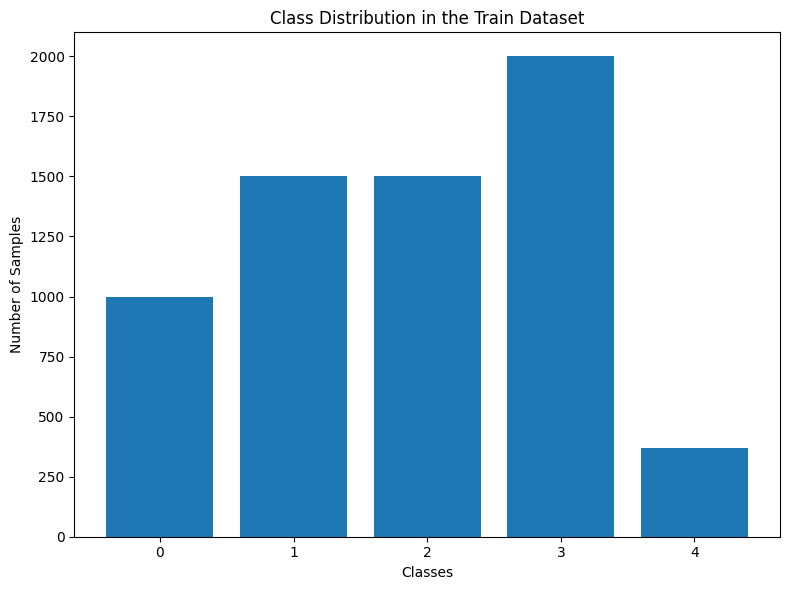

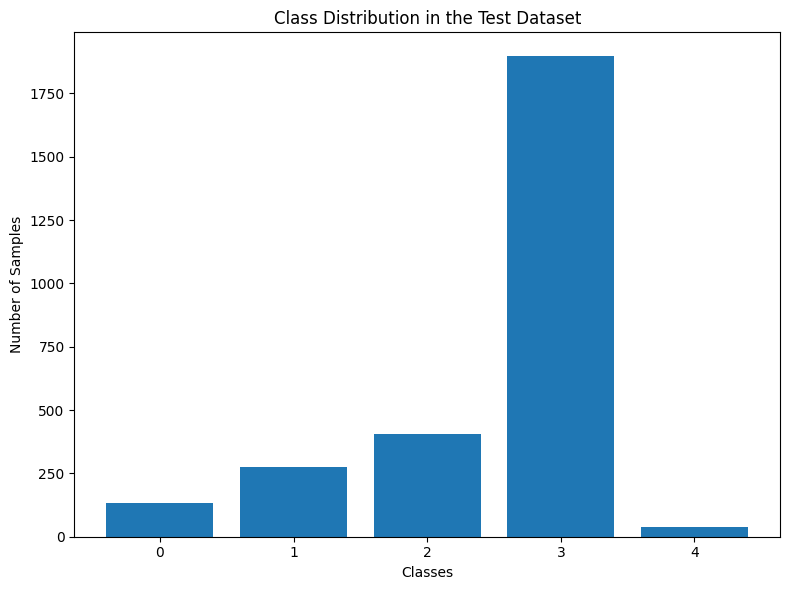

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

train_distribution = list((dict(Counter(train_dataset.targets))).values())
test_distribution = list((dict(Counter(test_dataset.targets))).values())

# 0 do nothing
# 1 steer left
# 2 steer right
# 3 gas
# 4 brake
class_names = [0, 1, 2, 3, 4]


plt.figure(figsize=(8, 6))
plt.bar(class_names, [train_distribution[i] for i in range(len(train_distribution))])
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in the Train Dataset')
#plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility if needed
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 6))
plt.bar(class_names, [test_distribution[i] for i in range(len(test_distribution))])
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in the Test Dataset')
#plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility if needed
plt.tight_layout()
plt.show()

# CNN1, the first model

Epoch [1/30], Step [100/100], Loss: 1.6752
Epoch [2/30], Step [100/100], Loss: 1.4130
Epoch [3/30], Step [100/100], Loss: 1.3783
Epoch [4/30], Step [100/100], Loss: 1.3672
Epoch [5/30], Step [100/100], Loss: 1.3526
Epoch [6/30], Step [100/100], Loss: 1.3155
Epoch [7/30], Step [100/100], Loss: 1.2363
Epoch [8/30], Step [100/100], Loss: 1.2093
Epoch [9/30], Step [100/100], Loss: 1.1963
Epoch [10/30], Step [100/100], Loss: 1.1751
Epoch [11/30], Step [100/100], Loss: 1.1681
Epoch [12/30], Step [100/100], Loss: 1.1648
Epoch [13/30], Step [100/100], Loss: 1.1677
Epoch [14/30], Step [100/100], Loss: 1.1498
Epoch [15/30], Step [100/100], Loss: 1.1398
Epoch [16/30], Step [100/100], Loss: 1.1397
Epoch [17/30], Step [100/100], Loss: 1.1322
Epoch [18/30], Step [100/100], Loss: 1.1246
Epoch [19/30], Step [100/100], Loss: 1.1240
Epoch [20/30], Step [100/100], Loss: 1.1169
Epoch [21/30], Step [100/100], Loss: 1.1191
Epoch [22/30], Step [100/100], Loss: 1.1125
Epoch [23/30], Step [100/100], Loss: 1.10

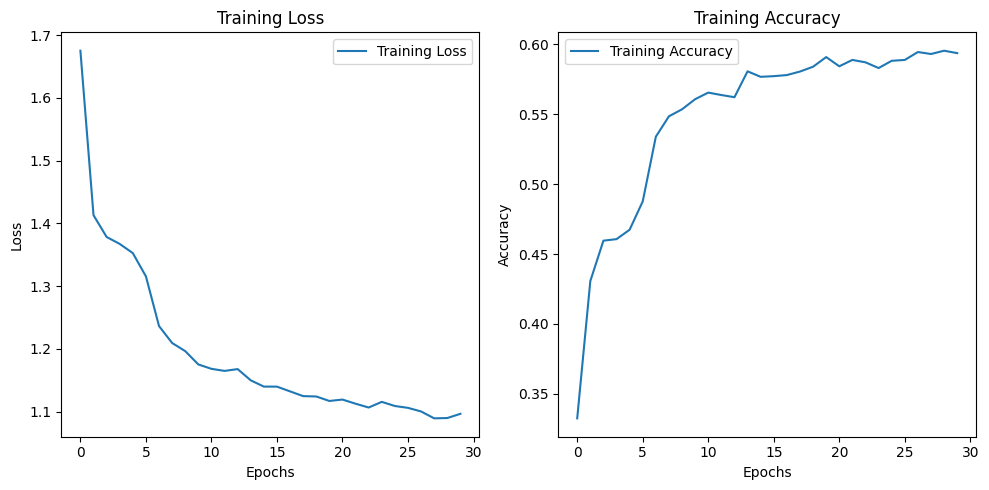

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets

# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 64 * 12 * 12)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)

learning_rate = 0.01

# as stated here https://stackoverflow.com/questions/55675345/should-i-use-softmax-as-output-when-using-cross-entropy-loss-in-pytorch
# CrossEntropyLoss() apply softmax so we don't need to do that in the network
criterion = nn.CrossEntropyLoss()


optimizer = optim.Adam(model.parameters(), lr=learning_rate)

import matplotlib.pyplot as plt

train_losses = []
train_accuracy = []

num_epochs = 30
for epoch in range(num_epochs):
    epoch_running_loss = 0.0
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        epoch_running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:
            print(f"Epoch [{epoch + 1}/{num_epochs}], "
                  f"Step [{i + 1}/{len(train_dataloader)}], "
                  f"Loss: {running_loss / 100:.4f}")
            running_loss = 0.0

    epoch_loss = epoch_running_loss / len(train_dataloader)
    epoch_accuracy = correct / total

    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)

print('Finished Training')
PATH = '/content/drive/MyDrive/Colab Notebooks/homework_2/cnn.pth'
torch.save(model.state_dict(), PATH)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
loaded_model = SimpleCNN()
loaded_model.load_state_dict(torch.load(PATH))
loaded_model = loaded_model.to(device)

Accuracy on the test dataset: 68.97%
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       133
           1       0.00      0.00      0.00       275
           2       0.00      0.00      0.00       406
           3       0.69      1.00      0.82      1896
           4       0.00      0.00      0.00        39

    accuracy                           0.69      2749
   macro avg       0.14      0.20      0.16      2749
weighted avg       0.48      0.69      0.56      2749



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


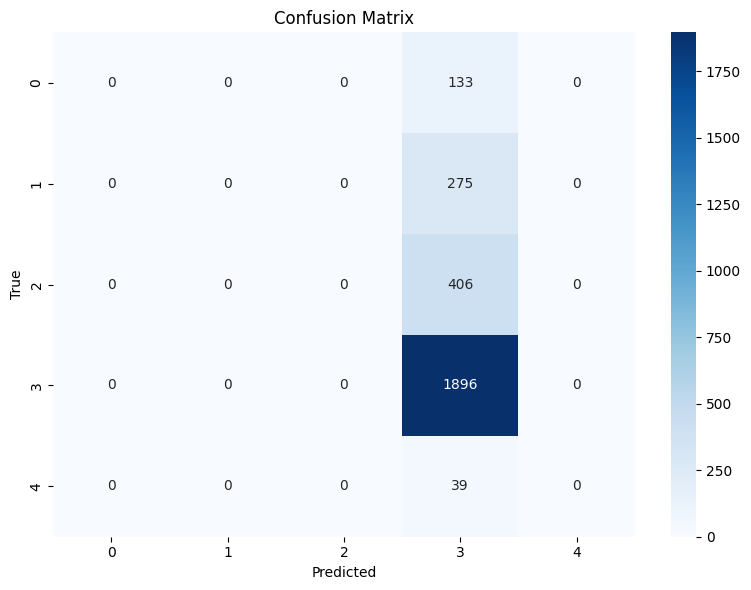

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np



loaded_model.eval()

n_correct = 0
n_samples = len(test_dataloader.dataset)
predictions = []
true_labels = []

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = loaded_model(images)
        outputs = outputs.to(device)

        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()

        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = 100 * n_correct / n_samples
print(f"Accuracy on the test dataset: {accuracy:.2f}%")

print("Classification Report:")
print(classification_report(true_labels, predictions))

conf_matrix = confusion_matrix(true_labels, predictions)

class_names = [str(i) for i in range(conf_matrix.shape[0])]

plt.figure(figsize=(8, 6))

sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()

plt.show()

In [ ]:
from torchsummary import summary

In [ ]:
summary(model, input_size=(3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 96, 96]             448
         MaxPool2d-2           [-1, 16, 48, 48]               0
            Conv2d-3           [-1, 32, 48, 48]           4,640
         MaxPool2d-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          18,496
         MaxPool2d-6           [-1, 64, 12, 12]               0
            Linear-7                  [-1, 128]       1,179,776
            Linear-8                    [-1, 5]             645
Total params: 1,204,005
Trainable params: 1,204,005
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 2.46
Params size (MB): 4.59
Estimated Total Size (MB): 7.16
----------------------------------------------------------------


# CNN2, the second model

Epoch [1/30], Step [100/100], Loss: 1.5260
Epoch [2/30], Step [100/100], Loss: 1.5022
Epoch [3/30], Step [100/100], Loss: 1.5011
Epoch [4/30], Step [100/100], Loss: 1.5015
Epoch [5/30], Step [100/100], Loss: 1.5014
Epoch [6/30], Step [100/100], Loss: 1.5010
Epoch [7/30], Step [100/100], Loss: 1.5015
Epoch [8/30], Step [100/100], Loss: 1.5014
Epoch [9/30], Step [100/100], Loss: 1.5008
Epoch [10/30], Step [100/100], Loss: 1.5016
Epoch [11/30], Step [100/100], Loss: 1.5011
Epoch [12/30], Step [100/100], Loss: 1.5006
Epoch [13/30], Step [100/100], Loss: 1.5009
Epoch [14/30], Step [100/100], Loss: 1.5014
Epoch [15/30], Step [100/100], Loss: 1.5005
Epoch [16/30], Step [100/100], Loss: 1.5008
Epoch [17/30], Step [100/100], Loss: 1.4995
Epoch [18/30], Step [100/100], Loss: 1.4965
Epoch [19/30], Step [100/100], Loss: 1.4650
Epoch [20/30], Step [100/100], Loss: 1.4101
Epoch [21/30], Step [100/100], Loss: 1.3882
Epoch [22/30], Step [100/100], Loss: 1.3707
Epoch [23/30], Step [100/100], Loss: 1.36

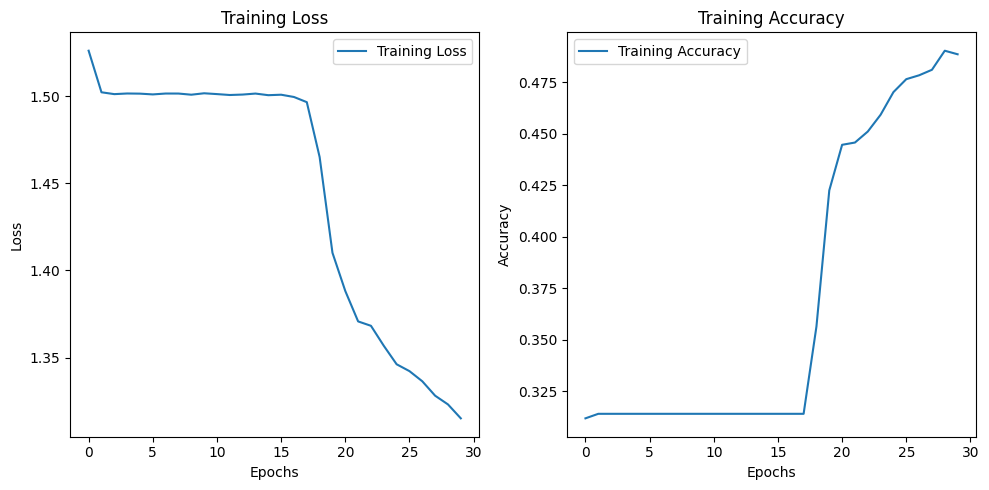

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = self.pool(torch.relu(self.conv5(x)))
        x = x.view(-1, 256 * 3 * 3)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = SimpleCNN().to(device)

learning_rate = 0.1

criterion = nn.CrossEntropyLoss()


optimizer = optim.SGD(model.parameters(), lr=learning_rate)

import matplotlib.pyplot as plt

train_losses = []
train_accuracy = []

num_epochs = 30
for epoch in range(num_epochs):
    epoch_running_loss = 0.0
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        epoch_running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:
            print(f"Epoch [{epoch + 1}/{num_epochs}], "
                  f"Step [{i + 1}/{len(train_dataloader)}], "
                  f"Loss: {running_loss / 100:.4f}")
            running_loss = 0.0


    epoch_loss = epoch_running_loss / len(train_dataloader)
    epoch_accuracy = correct / total

    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)

print('Finished Training')
PATH = '/content/drive/MyDrive/Colab Notebooks/homework_2/cnn2.pth'
torch.save(model.state_dict(), PATH)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
loaded_model = SimpleCNN()
loaded_model.load_state_dict(torch.load(PATH))
loaded_model = loaded_model.to(device)

Accuracy on the test dataset: 63.95%
Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.08      0.12       133
           1       0.20      0.35      0.26       275
           2       0.45      0.47      0.46       406
           3       0.80      0.77      0.79      1896
           4       0.00      0.00      0.00        39

    accuracy                           0.64      2749
   macro avg       0.35      0.33      0.33      2749
weighted avg       0.66      0.64      0.64      2749



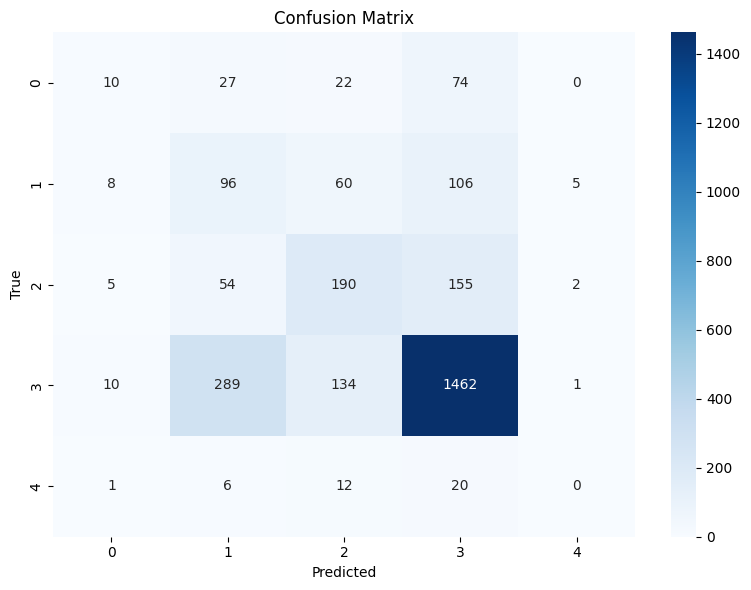

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np



loaded_model.eval()

n_correct = 0
n_samples = len(test_dataloader.dataset)
predictions = []
true_labels = []

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = loaded_model(images)
        outputs = outputs.to(device)

        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()

        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = 100 * n_correct / n_samples
print(f"Accuracy on the test dataset: {accuracy:.2f}%")

print("Classification Report:")
print(classification_report(true_labels, predictions))

conf_matrix = confusion_matrix(true_labels, predictions)

class_names = [str(i) for i in range(conf_matrix.shape[0])]  # Example: 0, 1, 2, ...

plt.figure(figsize=(8, 6))

sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()

plt.show()

In [ ]:
from torchsummary import summary

In [ ]:
summary(model, input_size=(3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 96, 96]             448
         AvgPool2d-2           [-1, 16, 48, 48]               0
            Conv2d-3           [-1, 32, 48, 48]           4,640
         AvgPool2d-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          18,496
         AvgPool2d-6           [-1, 64, 12, 12]               0
            Conv2d-7          [-1, 128, 12, 12]          73,856
         AvgPool2d-8            [-1, 128, 6, 6]               0
            Conv2d-9            [-1, 256, 6, 6]         295,168
        AvgPool2d-10            [-1, 256, 3, 3]               0
           Linear-11                  [-1, 128]         295,040
           Linear-12                    [-1, 5]             645
Total params: 688,293
Trainable params: 688,293
Non-trainable params: 0
-------------------------------